Target:
1. Lets try to increase Train accuracy and let’s add Batch Normalization for each block, never add Batch Normalization to the last layer
2. If not able to achieve the target, let’s add Regularization (Dropout) to our model
3. Results:
    * a.	Parameters: 10,490
    * b.	Best Train Accuracy: 99
    * c.	Best Test Accuracy: 99.28
4. Analysis:
    * a.	Initially without drop, we were able to achieve 99.4+ train accuracy consistently we even reached 99.7
    * b.	But still there is some overfitting can be seen, so adding 0.1 dropout to our model


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


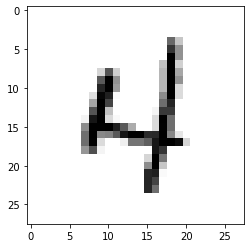

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

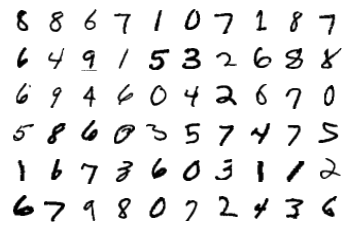

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        #Input 28, output 26, 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )
        #Input 26, output 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3,3), padding = 0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        #Input 24, output 22

        self.pool1 = nn.MaxPool2d(2, 2)
        #reduce input by half

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3,3), padding = 0, bias = False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        #input 11, output 9
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding= 0, bias =False ),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        #input 9, output 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3), padding=0, bias = False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        #input 7, output 5
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )#input 5, output 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        self.dropout = nn.Dropout(dropout_value)
        #input 5, output 1

    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.pool1(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.convblock7(x)
      x = self.gap(x)
      x = self.convblock8(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
              ReLU-7           [-1, 20, 24, 24]               0
            Conv2d-8           [-1, 20, 22, 22]           3,600
       BatchNorm2d-9           [-1, 20, 22, 22]              40
          Dropout-10           [-1, 20, 22, 22]               0
             ReLU-11           [-1, 20, 22, 22]               0
        MaxPool2d-12           [-1, 20, 11, 11]               0
           Conv2d-13             [-1, 10, 9, 9]           1,800
      BatchNorm2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1431581825017929 Batch_id=468 Accuracy=76.31: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.1347, Accuracy: 9688/10000 (96.88%)

EPOCH: 1


Loss=0.08380719274282455 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0758, Accuracy: 9788/10000 (97.88%)

EPOCH: 2


Loss=0.12219787389039993 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0822, Accuracy: 9761/10000 (97.61%)

EPOCH: 3


Loss=0.04011078178882599 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0580, Accuracy: 9838/10000 (98.38%)

EPOCH: 4


Loss=0.07179293781518936 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0426, Accuracy: 9873/10000 (98.73%)

EPOCH: 5


Loss=0.04966280236840248 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0387, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.02688952349126339 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0431, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.021988989785313606 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]



Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.06940209120512009 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]



Test set: Average loss: 0.0335, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.015096883289515972 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]



Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.04248315468430519 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0293, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.06151057779788971 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]



Test set: Average loss: 0.0306, Accuracy: 9899/10000 (98.99%)

EPOCH: 12


Loss=0.013972975313663483 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.0320, Accuracy: 9894/10000 (98.94%)

EPOCH: 13


Loss=0.007724339608103037 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0286, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.005511689931154251 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:22<00:00, 20.95it/s]



Test set: Average loss: 0.0300, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.010893180035054684 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0255, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.01029871590435505 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]



Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.11839603632688522 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 18


Loss=0.031047508120536804 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0264, Accuracy: 9914/10000 (99.14%)

EPOCH: 19


Loss=0.07886899262666702 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0252, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

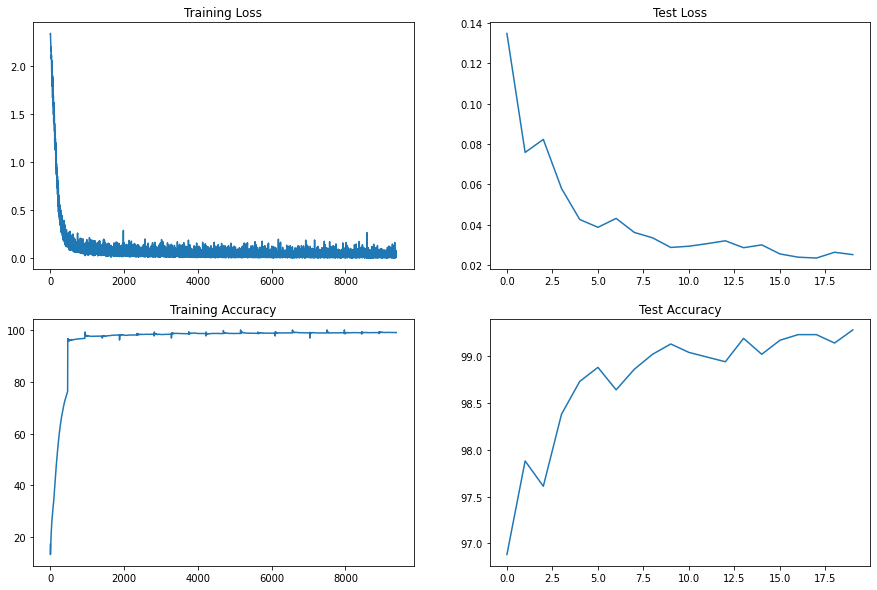

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")